In [1]:
import gym
env = gym.make('CartPole-v0')

In [2]:
import random
import numpy as np
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, 1 - done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [3]:
replay_buffer = ReplayBuffer(1000)

In [4]:
import math
epsilon_start = 1
epsilon_final = 0.01
epsilon_decay = 500
epsilon_by_frame = lambda frame_idx : epsilon_final + (epsilon_start - epsilon_final) \
                                * math.exp(-1 * frame_idx / epsilon_decay)

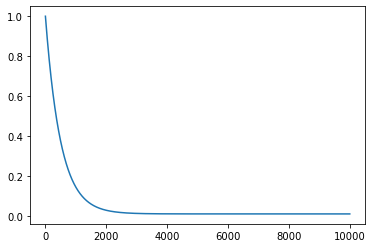

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([epsilon_by_frame(i) for i in range(10000)])

## Dueling DQN

In [6]:
import torch.nn as nn

class DuelingDQN(nn.Module):
    def __init__(self, nums_input, nums_output):
        super(DuelingDQN, self).__init__()
        self.nums_input = nums_input
        self.nums_output = nums_output
        
        self.feature = nn.Sequential(
            nn.Linear(nums_input, 128),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, nums_output)
        )
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value = self.value(x)
        return value + advantage - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            q_value = self.forward(state)
            action = torch.argmax(q_value, dim=1).numpy()[0]
            
        else:
            action = random.randrange(self.nums_output)
        return action

In [7]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
current_model = DuelingDQN(nums_input=env.observation_space.shape[0], nums_output=env.action_space.n).to(device)
target_model = DuelingDQN(nums_input=env.observation_space.shape[0], nums_output=env.action_space.n).to(device)

In [8]:
import torch.optim as optim
optimizer = optim.Adam(current_model.parameters())

In [9]:
def update_target(current, target):
    target.load_state_dict(current.state_dict())
update_target(current_model, target_model)

## 计算TD误差

In [13]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state = torch.tensor(state, dtype=torch.float32)
    action = torch.tensor(action)
    reward = torch.tensor(reward)
    next_state = torch.tensor(next_state, dtype=torch.float32)
    done = torch.tensor(done)
    
    q_values = current_model(state)
    target_q_values = target_model(next_state)
    
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    target_q_value = target_q_values.max(1)[0]
    expected_q_value = reward + gamma * target_q_value * done
    
    loss = (expected_q_value - q_value).pow(2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [14]:
from IPython.display import clear_output
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

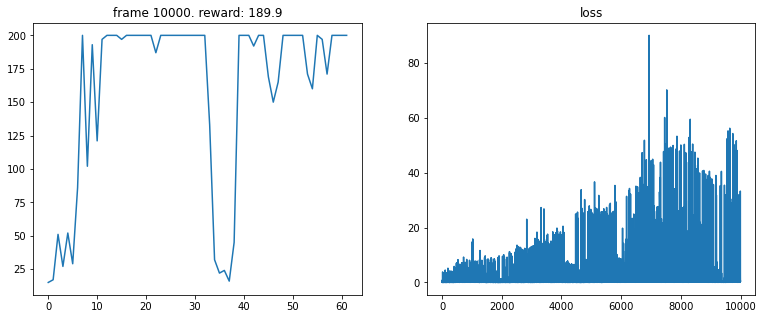

In [16]:
num_frames = 10000
batch_size = 32
gamma = 0.99

all_rewards = []
losses = []

epsilode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, infor = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    epsilode_reward += reward
    state = next_state
    
    if done:
        state = env.reset()
        all_rewards.append(epsilode_reward)
        epsilode_reward = 0
    
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        
        losses.append(loss.item())
    
    if frame_idx % 200 == 0:
        update_target(current_model, target_model)
    
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, losses)